# Concrete ML Scalability

## Imports

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from concrete.ml.sklearn import LogisticRegression, LinearSVC, DecisionTreeClassifier, RandomForestClassifier, XGBClassifier, NeuralNetClassifier

## Create Datasets

In [2]:
# Create a synthetic dataset
observation_sizes = [503]
feature_sizes = [10, 100, 1000]

datasets = []

# Create datasets with different sizes
for n_obs in observation_sizes:
    for n_feat in feature_sizes:
        X, y = make_classification(n_samples=n_obs, n_features=n_feat)
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=3)
        datasets.append((x_train, x_test, y_train, y_test))

## Benchmark

In [3]:
n_bits = 2

In [4]:
results = {'n_obs': [], 'n_feat': [], 'clf': [], 'eval_total': [], 'eval_single': []}

# Train and evaluate the models
for split in datasets:
    x_train, x_test, y_train, y_test = split
    for clf in [LogisticRegression, LinearSVC, DecisionTreeClassifier,RandomForestClassifier, XGBClassifier, NeuralNetClassifier]:
        # Initialize the model
        if clf.__name__ == 'NeuralNetClassifier':
            model = clf(verbose=0, **{'module__n_layers': 2, 'module__n_w_bits': n_bits, 'module__n_a_bits': n_bits})
        else:
            model = clf(n_bits=n_bits)
        # Train the model
        model.fit(x_train, y_train)
        # Evaluate the model
        model.compile(x_train)
        # Evaluate the model
        start_time = time.time()
        y_pred = model.predict(x_test, fhe='execute')
        eval_total = time.time() - start_time
        # Save the results
        results['n_obs'].append(x_train.shape[0])
        results['n_feat'].append(x_train.shape[1])
        results['clf'].append(clf.__name__)
        results['eval_total'].append(eval_total)
        results['eval_single'].append(eval_total / len(y_test))

# Evaluate

In [5]:
# results to dataframe
df = pd.DataFrame(results)
df_excluding_nn = df[df['clf'] != 'NeuralNetClassifier']

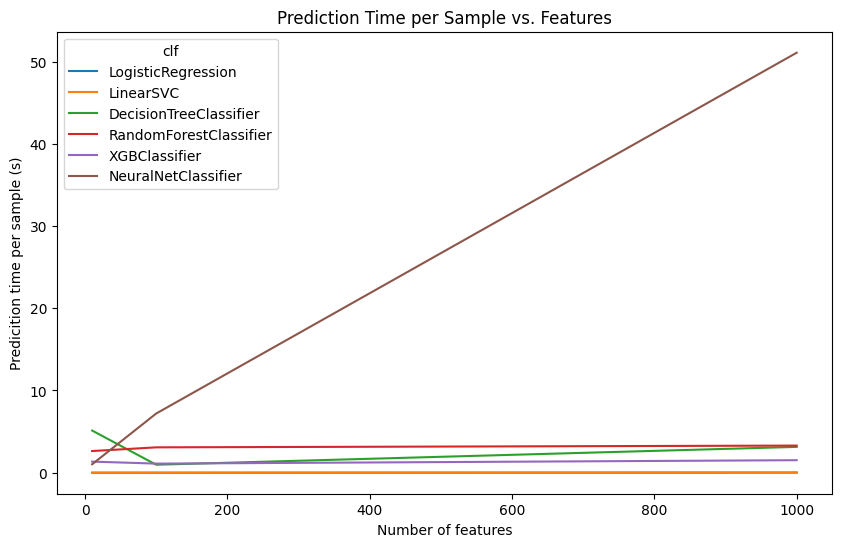

In [6]:
# evaluation time per sample n_feat
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='n_feat', y='eval_single', hue='clf', ci=None)
plt.xlabel('Number of features')
plt.ylabel('Predicition time per sample (s)')
plt.title('Prediction Time per Sample vs. Features')
plt.show()

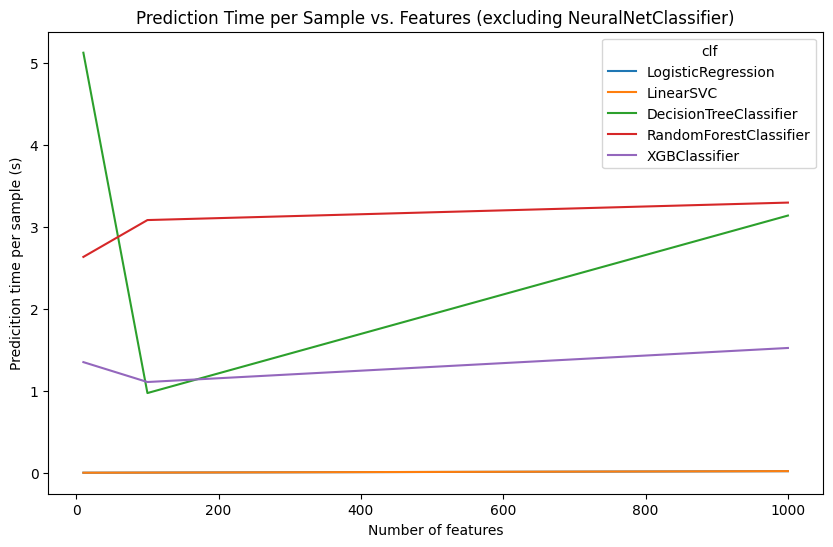

In [7]:
# evaluation time per sample n_feat excluding NeuralNetClassifier
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_excluding_nn, x='n_feat', y='eval_single', hue='clf', ci=None)
plt.xlabel('Number of features')
plt.ylabel('Predicition time per sample (s)')
plt.title('Prediction Time per Sample vs. Features (excluding NeuralNetClassifier)')
plt.show()

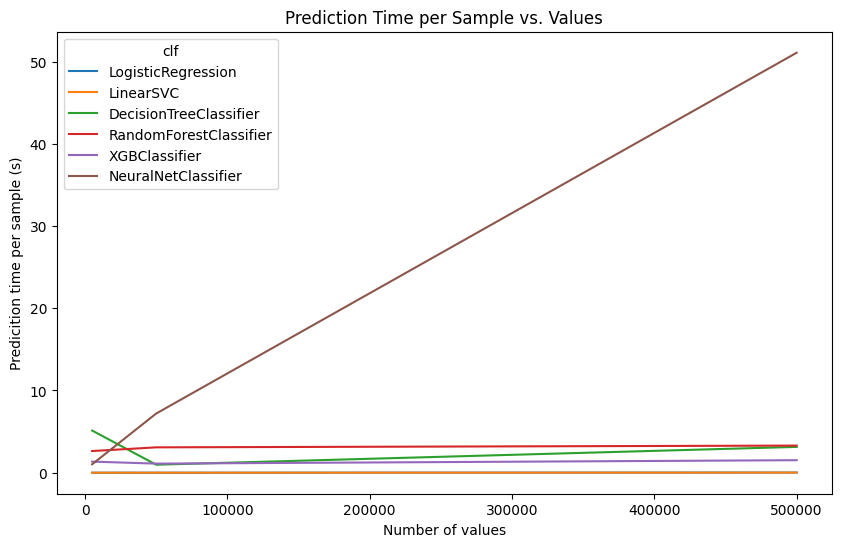

In [8]:
# evaluation time per sample n_obs * n_feat
df['n_values'] = df['n_obs'] * df['n_feat']
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='n_values', y='eval_single', hue='clf', ci=None)
plt.xlabel('Number of values')
plt.ylabel('Predicition time per sample (s)')
plt.title('Prediction Time per Sample vs. Values')
plt.show()

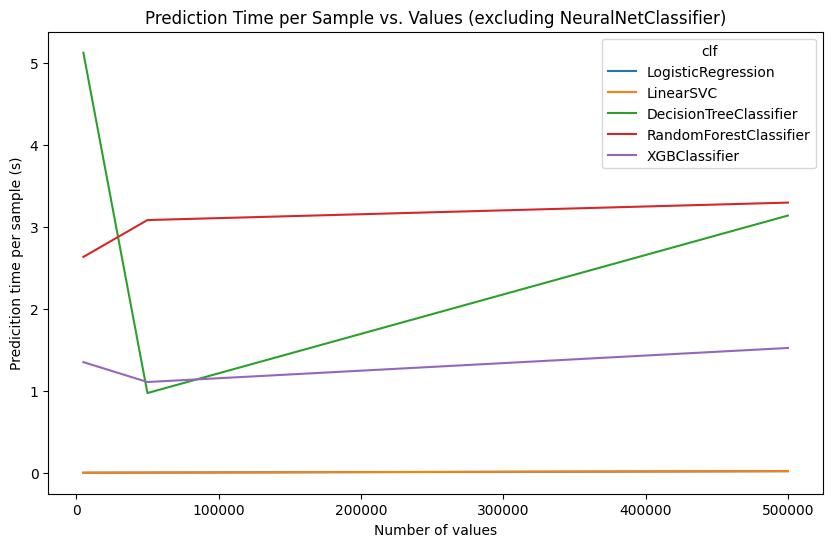

In [9]:
# evaluation time per sample n_obs * n_feat excluding NeuralNetClassifier
df_excluding_nn['n_values'] = df_excluding_nn['n_obs'] * df_excluding_nn['n_feat']
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_excluding_nn, x='n_values', y='eval_single', hue='clf', ci=None)
plt.xlabel('Number of values')
plt.ylabel('Predicition time per sample (s)')
plt.title('Prediction Time per Sample vs. Values (excluding NeuralNetClassifier)')
plt.show()